<a href="https://colab.research.google.com/github/GaneshKumar508/AI-Internship/blob/main/Spotify_Minor_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd, numpy as np
df = pd.read_csv('spotify dataset.csv')
df.shape
df.head()
df.info()
df.describe().T
df.isnull().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-null  int64  
 14  loudne

,0
track_name,5
track_artist,5
track_album_name,5
track_id,0
track_popularity,0
track_album_id,0
track_album_release_date,0
playlist_name,0
playlist_id,0
playlist_genre,0


In [ ]:
df.drop_duplicates(inplace=True)
if 'duration_ms' in df.columns:
    df['duration_min'] = df['duration_ms'] / 60000
num_cols = df.select_dtypes(include=['float64','int64']).columns.tolist()
df[num_cols] = df[num_cols].fillna(df[num_cols].median())
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
df[cat_cols] = df[cat_cols].fillna('Unknown')

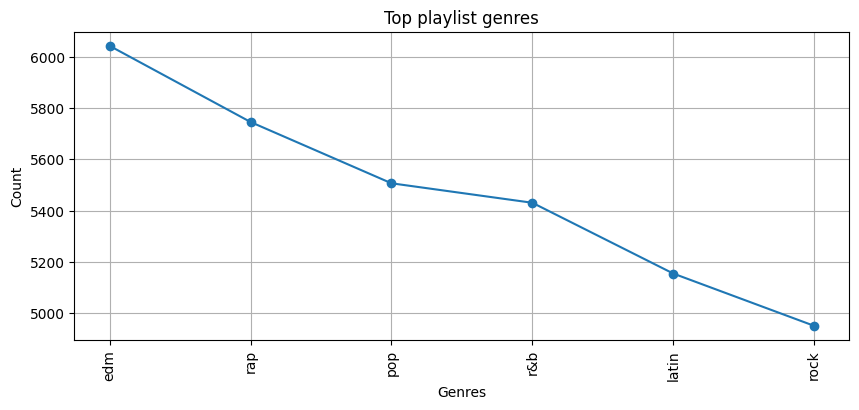

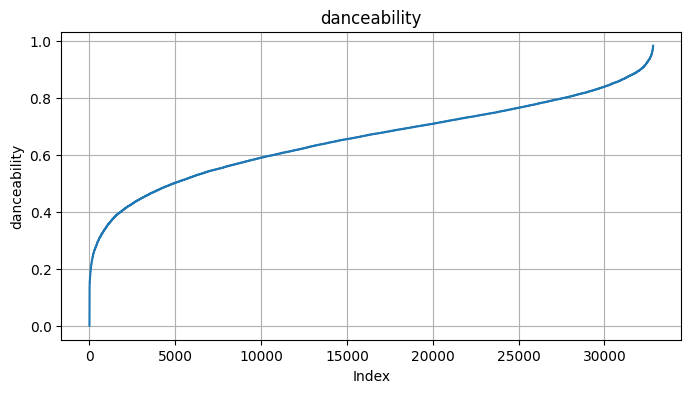

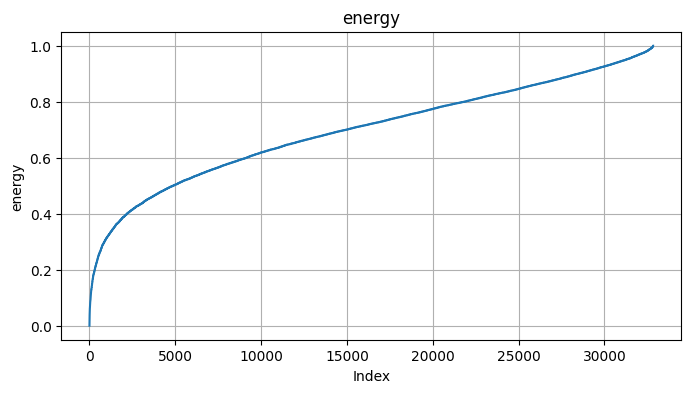

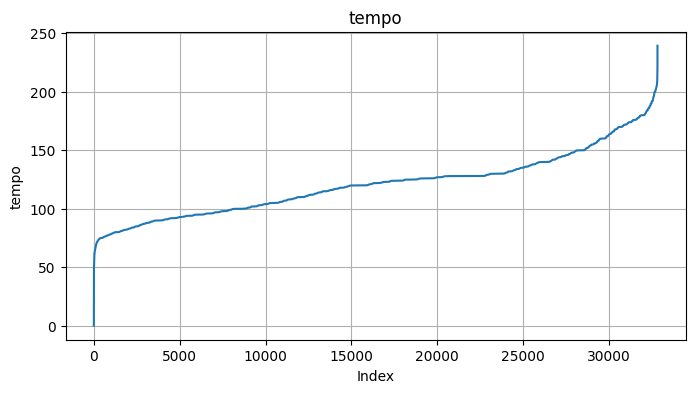

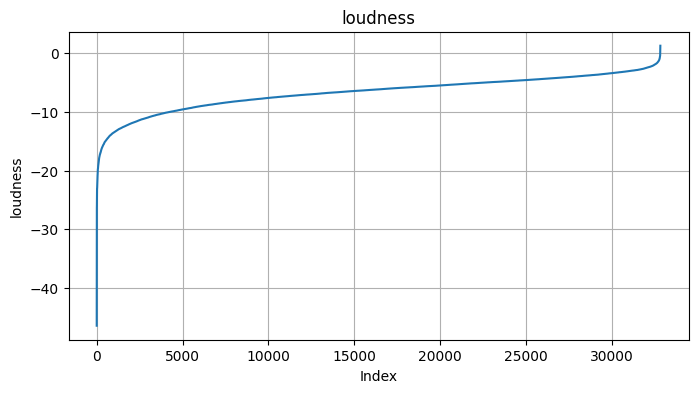

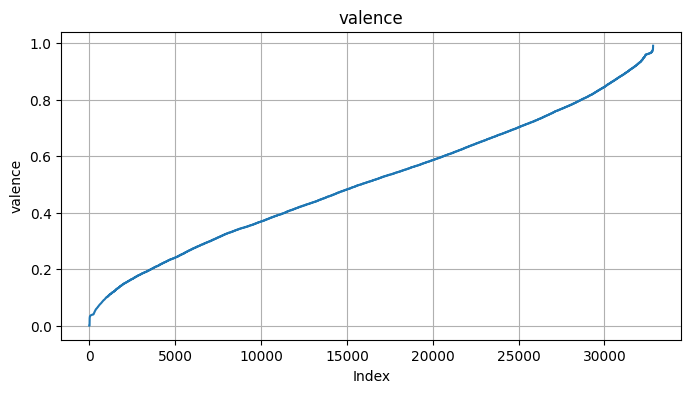

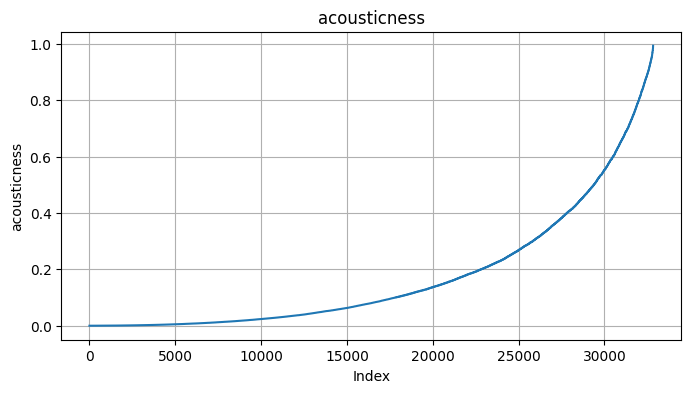

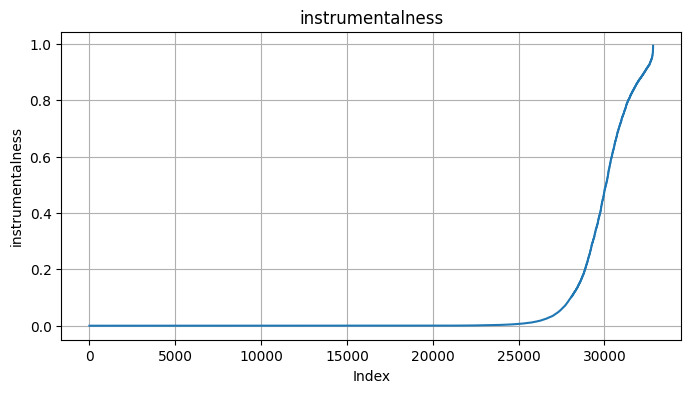

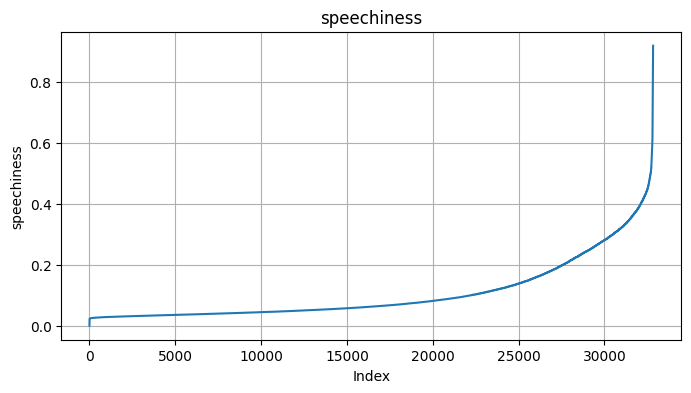

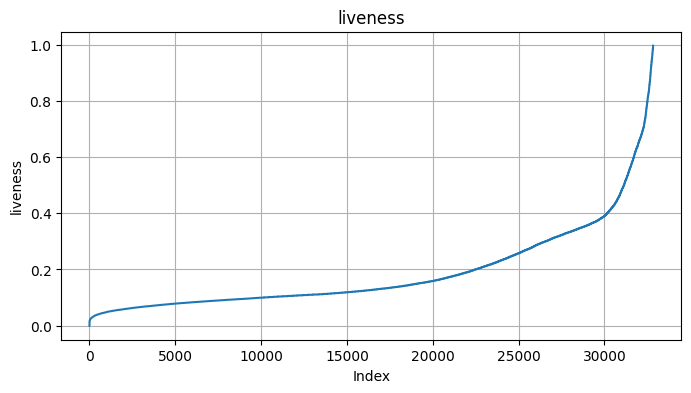

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
plt.figure(figsize=(10,4))
df['playlist_genre'].value_counts().head(20).plot(kind='line', marker='o')
plt.title('Top playlist genres')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()
features = [
    'danceability','energy','tempo','loudness','valence',
    'acousticness','instrumentalness','speechiness','liveness'
]
for f in features:
    if f in df.columns:
        plt.figure(figsize=(8,4))
        df[f].dropna().sort_values().reset_index(drop=True).plot(kind='line')
        plt.title(f)
        plt.xlabel('Index')
        plt.ylabel(f)
        plt.grid(True)
        plt.show()


<Axes: >

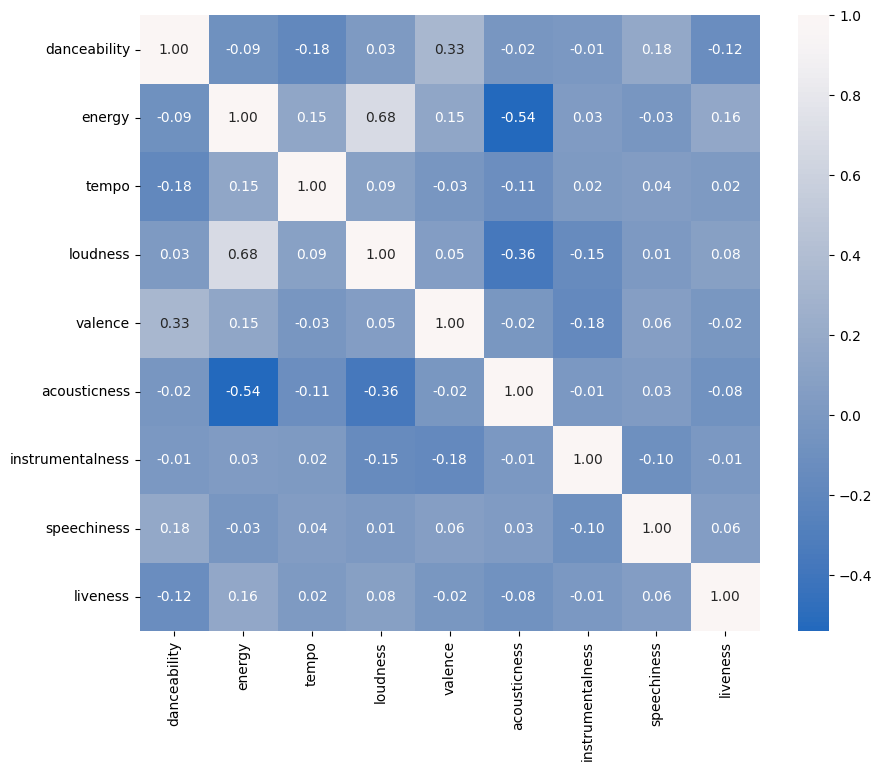

In [ ]:
corr = df[features].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', center=1)


In [ ]:
use_features = [f for f in features if f in df.columns]
X = df[use_features].copy()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
import joblib
joblib.dump(scaler, 'scaler.joblib')


['scaler.joblib']

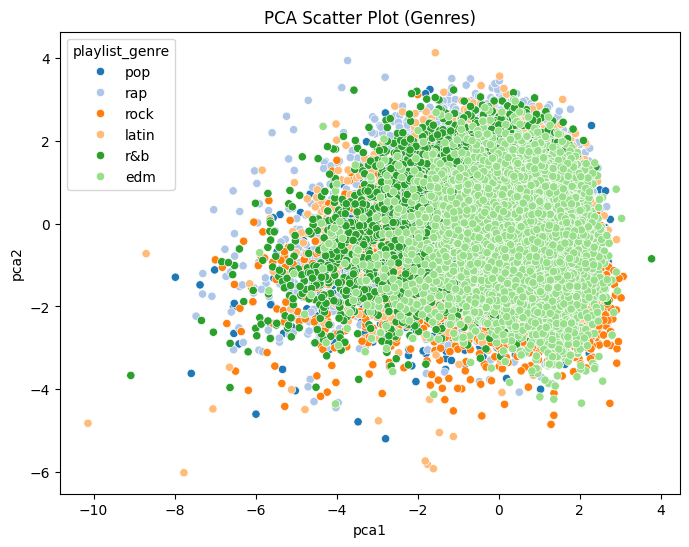

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)
df['pca1'], df['pca2'] = X_pca[:, 0], X_pca[:, 1]
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='pca1',
    y='pca2',
    hue='playlist_genre',
    data=df,
    palette='tab20',
    legend='full'
)
plt.title("PCA Scatter Plot (Genres)")
plt.show()


Text(0, 0.5, 'Silhouette score')

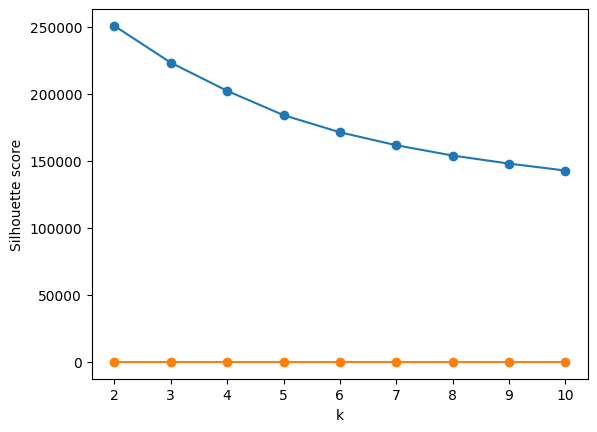

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled[:5000])

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia = []
sil_scores = []
K = range(2,11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_scaled)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, km.labels_))
plt.plot(K, inertia, '-o'); plt.xlabel('k'); plt.ylabel('Inertia')
plt.plot(K, sil_scores, '-o'); plt.xlabel('k'); plt.ylabel('Silhouette score')



In [ ]:
best_k = 4   # example — set after elbow/silhouette
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit(X_scaled)
df['cluster'] = kmeans.labels_
joblib.dump(kmeans, 'kmeans_model.joblib')

['kmeans_model.joblib']

In [ ]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.6, min_samples=5).fit(X_scaled)
df['dbscan_cluster'] = db.labels_   # -1 is noise
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=best_k).fit(X_scaled)
df['agg_cluster'] = agg.labels_
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
print('silhouette', silhouette_score(X_scaled, df['cluster']))
print('db', davies_bouldin_score(X_scaled, df['cluster']))
print('ch', calinski_harabasz_score(X_scaled, df['cluster']))

silhouette 0.15189136388588803
db 1.8308085712022848
ch 5054.587515802592


In [ ]:
def cluster_purity(df, true_label='playlist_genre', cluster_label='cluster'):
    ct = pd.crosstab(df[cluster_label], df[true_label])
    return np.sum(ct.max(axis=1)) / ct.values.sum()

print('Purity:', cluster_purity(df, 'playlist_genre', 'cluster'))


Purity: 0.2934852130478482


In [ ]:
pd.crosstab(df['cluster'], df['playlist_genre']).apply(lambda r: r/r.sum(), axis=1)


playlist_genre,edm,latin,pop,r&b,rap,rock
cluster,,,,,,
0,0.270697,0.094184,0.202518,0.077185,0.109253,0.246164
1,0.097140,0.236097,0.152249,0.194640,0.245294,0.074580
2,0.045421,0.117690,0.164215,0.326958,0.163295,0.182420
3,0.577487,0.078643,0.112182,0.040093,0.098304,0.093292


<Axes: xlabel='cluster'>

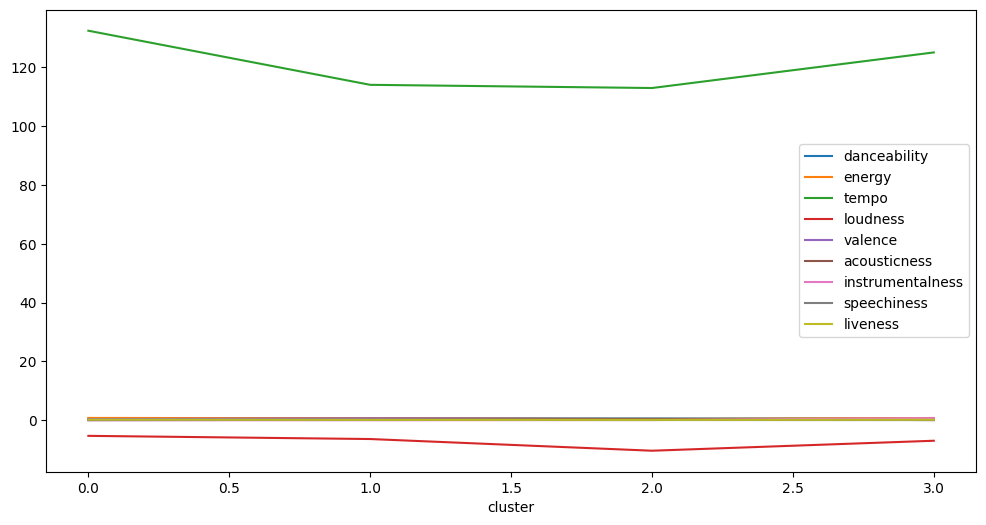

In [ ]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=use_features)
centers = scaler.inverse_transform(centers)
cluster_profiles = df.groupby('cluster')[use_features].mean()
cluster_profiles.plot(kind='line', figsize=(12,6))


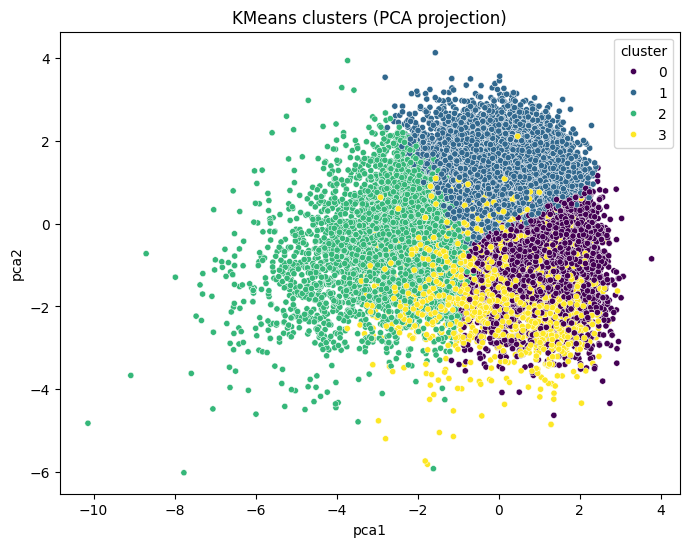

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='pca1', y='pca2',
    hue='cluster',
    palette='viridis',
    data=df, s=20
)
plt.title('KMeans clusters (PCA projection)')
plt.show()


In [ ]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=6, metric='euclidean').fit(X_scaled)
def recommend_by_track(track_id_col_value, n=5):
    idx = df.index[df['track_id'] == track_id_col_value].tolist()
    if not idx:
        return pd.DataFrame()
    idx = idx[0]
    distances, indices = nn.kneighbors([X_scaled[idx]])
    recs = df.iloc[indices[0][1:n+1]][['track_id','track_name','artist_name','playlist_genre','cluster']]
    return recs
recommend_by_track('SOME_TRACK_ID', n=5)
def recommend_cluster_based(track_id, n=5):
    idx = df.index[df['track_id']==track_id][0]
    cl = df.loc[idx,'cluster']
    candidates = df[df['cluster']==cl].index
    from sklearn.metrics import pairwise_distances
    dists = pairwise_distances([X_scaled[idx]], X_scaled[candidates])[0]
    top_idxs = np.array(candidates)[np.argsort(dists)[1:n+1]]
    return df.loc[top_idxs, ['track_id','track_name','artist_name','playlist_genre']]
    df.to_csv('spotify_clustered.csv', index=False)